In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
import pandas as pd
import numpy as np
np.random.seed(42)
PATH = '/Users/orendar/Downloads/dataverse_files/'

In [2]:
train_df = pd.read_csv(f'{PATH}train.csv', index_col = 0)
test_df = pd.read_csv(f'{PATH}test.csv',  index_col = 0)

In [3]:
train_df.head().T

,1,2,3,4,5
year,2002,2002,2002,2002,2002
camp.length,23,23,23,23,23
deminc,1,1,1,1,1
base.poll,45.7447,45.7447,45.7447,45.7447,45.7447
base.und,6,6,6,6,6
office,0,0,0,0,0
d.gone.neg,0,0,1,1,1
d.gone.neg.l1,0,0,1,1,1
d.gone.neg.l2,0,0,0,1,1
d.neg.frac.l3,0,0,0,0,0.0714286


In [4]:
cat_features = ["deminc", "d.gone.neg.l1", "d.gone.neg.l2", "office", "camp.length",
                "base.und", "y2000", "y2002", "y2004", "y2006"]

cont_features = ["r.neg.frac.l2", "r.neg.frac.l3", "rep.contrib.l1", 
                 "rep.contrib.l2", "dem.contrib.l1", "dem.contrib.l2", "num.rep.l1",
                 "num.rep.l2", "num.dem.l1", "num.dem.l2", "d.neg.frac.l3", "undother.l2",
                 "undother.l1", "dem.polls.l1", "dem.polls.l2",
                "neg.rep.l1", "neg.rep.l2", "base.poll", "week"]

target = "d.gone.neg"

In [5]:
train_df = train_df[cat_features+cont_features+[target]]
test_df = test_df[cat_features+cont_features+[target]]

for v in cat_features: train_df[v] = train_df[v].astype('category').cat.as_ordered()
apply_cats(test_df, train_df)    

for v in cont_features:
    train_df[v] = train_df[v].astype('float32')
    test_df[v] = test_df[v].astype('float32')

x_train, y_train, nas, mapper = proc_df(train_df, target, do_scale=True)
x_test, y_test, nas, mapper = proc_df(test_df, target, do_scale=True, mapper=mapper, na_dict=nas)

for v in cat_features: x_train[v] = x_train[v].astype('category').cat.as_ordered()
apply_cats(x_test, x_train)    

for v in cont_features:
    x_train[v] = x_train[v].astype('float32')
    x_test[v] = x_test[v].astype('float32')

In [6]:
x = pd.concat([x_test, x_train])
y = np.int64(np.concatenate([y_test, y_train]))
#y = np.int64(to_categorical(np.concatenate([y_test, y_train])))
# val_idx = list(range(len(x_test)))
val_idx = list(range(len(x_test)))
#val_idx = None
x_test.shape, x_train.shape, x.shape, y_test.shape, y_train.shape, y.shape

((287, 43), (863, 43), (1150, 43), (287,), (863,), (1150,))

In [7]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, x, y, cat_flds=cat_features, bs=128, is_reg=False)

In [8]:
cat_sz = [(c, len(x[c].cat.categories)+1) for c in cat_features]; cat_sz

[('deminc', 3),
 ('d.gone.neg.l1', 3),
 ('d.gone.neg.l2', 3),
 ('office', 3),
 ('camp.length', 23),
 ('base.und', 40),
 ('y2000', 3),
 ('y2002', 3),
 ('y2004', 3),
 ('y2006', 3)]

In [9]:
emb_szs = [(c, max(20, (c+1)//2)) for _,c in cat_sz]; emb_szs

[(3, 20),
 (3, 20),
 (3, 20),
 (3, 20),
 (23, 20),
 (40, 20),
 (3, 20),
 (3, 20),
 (3, 20),
 (3, 20)]

In [13]:
m = md.get_learner(emb_szs, len(x.columns)-len(cat_features),
                   0.5, 2, [1000,500], [0.35,0.45])

lr = 4e-4
wd = 1e-4

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.467]        


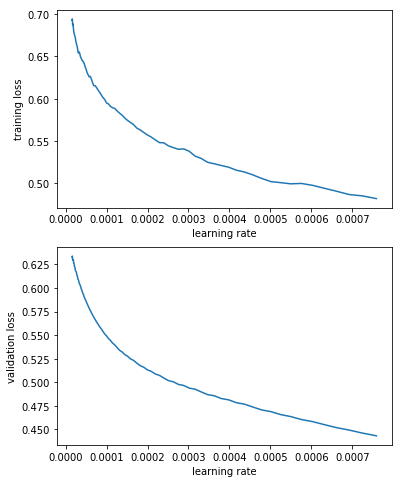

In [14]:
m.lr_find2(start_lr=1e-5, end_lr=1e-3, wds=wd)
m.sched.plot()

In [15]:
m.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(3, 10, 0.95, 0.85), metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                
    0      0.623769   0.516565   0.773519  
    1      0.573604   0.459987   0.780488                
    2      0.540467   0.432914   0.773519                
    3      0.519813   0.417272   0.777003                
    4      0.504395   0.401191   0.811847                
    5      0.487152   0.380383   0.84669                 
    6      0.474425   0.360511   0.857143                
    7      0.458055   0.340682   0.867596                
    8      0.443175   0.326413   0.874564                
    9      0.430287   0.314079   0.881533                
    10     0.420211   0.310152   0.881533                
    11     0.408392   0.306303   0.878049                
    12     0.39575    0.288875   0.878049                
    13     0.386006   0.28747    0.874564                
    14     0.380156   0.28936    0.874564                
    15     0.371622   0.291947   0.867596                
    16     0.364633   0.2900

[array([0.28287]), 0.8745644599303136]

In [16]:
from sklearn.metrics import *
def softmax(preds): return [np.exp(pred) / np.exp(pred).sum() for pred in preds]
def rmse(preds): return mean_squared_error(y_test, preds)**.5
def auroc(preds): return roc_auc_score(y_test, preds)
def acc(preds): return accuracy_score(y_test, preds)
def logloss(preds): return log_loss(y_test, preds)

In [17]:
preds = m.predict()
m_preds_pos = np.array([softmax(preds)[i][1] for i in range(len(preds))])
m_clas = m_preds_pos >= 0.5

In [18]:
acc(m_clas), rmse(m_preds_pos), auroc(m_preds_pos), logloss(m_preds_pos)

(0.8745644599303136,
 0.2997085045323911,
 0.9494949494949495,
 0.2828741180886943)

In [ ]:
(0.8745644599303136,
 0.2997085045323911,
 0.9494949494949495,
 0.2828741180886943)